# Youtube Trend Analysis 
### 1.  Getting familiar with the dataset
### 2.  Sentiment Scoring with comments 
### 3.  Meaningful EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import matplotlib as mpl
%matplotlib inline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### 1. Getting familiar with the dataset -- global one 

In [2]:
comments =  pd.read_csv("UScomments.csv", error_bad_lines = False)
comments.head(2)

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
C:\Users\fcbmu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0


In [3]:
videos =  pd.read_csv("USvideos.csv", error_bad_lines = False)
videos.head(2)

b'Skipping line 2401: expected 11 fields, saw 21\nSkipping line 2800: expected 11 fields, saw 21\nSkipping line 5297: expected 11 fields, saw 12\nSkipping line 5299: expected 11 fields, saw 12\nSkipping line 5300: expected 11 fields, saw 12\nSkipping line 5301: expected 11 fields, saw 12\n'


,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09


In [4]:
# load the categories from json file 
f = open("GB_category_id.json")
data = f.read()
f.close()
out = json.loads(data)
categories = pd.DataFrame([
    {'category_id':x['id'],
     'category':x['snippet']['title'],
     'assignable':x['snippet']['assignable']
    } for x in out['items']
])

In [5]:
# left join with categories
categories['category_id'] = categories['category_id'].astype(int)
videos = videos.merge(categories, on = 'category_id', how = 'left')

In [6]:
videos = videos.iloc[:, :-1]
videos.head(2)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,category
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09,Science & Technology


### 2.  Sentiment Scoring on comments using VADER

In [321]:
sid = SentimentIntensityAnalyzer()
comments['neg'] = comments['comment_text'].apply(lambda x:sid.polarity_scores(str(x))['neg'])
comments['neu'] = comments['comment_text'].apply(lambda x:sid.polarity_scores(str(x))['neu'])
comments['pos'] = comments['comment_text'].apply(lambda x:sid.polarity_scores(str(x))['pos'])
comments['compound'] = comments['comment_text'].apply(lambda x:sid.polarity_scores(str(x))['compound'])
# now we have scoring!
comments.head(2)

,video_id,comment_text,likes,replies,neg,neu,pos,compound
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,0.0,1.0,0.0,0.0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0,0.0,1.0,0.0,0.0


In [322]:
comments['compound'].min() # overall rating is range -1.0 to 0.99

-1.0

In [323]:
scoring_2_cols = comments[['video_id', 'compound']]
scoring_2_cols.head()

,video_id,compound
0,XpVt6Z1Gjjo,0.0000
1,XpVt6Z1Gjjo,0.0000
2,XpVt6Z1Gjjo,0.0000
3,XpVt6Z1Gjjo,0.4648
4,XpVt6Z1Gjjo,0.0000


In [324]:
# get the average scoring per video_id
scoring_2_cols['avg_score']  = scoring_2_cols.groupby("video_id")['compound'].transform('mean')

<ipython-input-324-f4b7b8a93162>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [325]:
del scoring_2_cols['compound']
scoring_2_cols.head(2)

,video_id,avg_score
0,XpVt6Z1Gjjo,0.069781
1,XpVt6Z1Gjjo,0.069781


In [326]:
# merge back to the main videos df
videos = videos.merge(scoring_2_cols, on = "video_id")
videos.head(2)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,category,avg_score
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment,0.069781
1,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment,0.069781


In [327]:
videos['OverallSentiment'] = 'Unknown'
videos.loc[videos['avg_score'] == 0, 'OverallSentiment'] = 'neutral'
videos.loc[videos['avg_score'] > 0, 'OverallSentiment'] = 'positive'
videos.loc[videos['avg_score'] < 0, 'OverallSentiment'] = 'negative'
videos.head(2)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,category,avg_score,OverallSentiment
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment,0.069781,positive
1,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment,0.069781,positive


## 3.  Meaningful EDA 

### 3.1 US Videos Dataset

In [16]:
# Check for any duplicate values

# Dim of yt_us df
display(videos.shape)

# Duplicate videos?
display('video_id: ' + str(videos.index.nunique()))

# Any unique value in each variable
display(videos.nunique())

(7992, 15)

'video_id: 7992'

video_id          2364
title             2398
channel_title     1230
category_id         16
tags              2204
views             7939
likes             6624
dislikes          2531
comment_total     4152
thumbnail_link    2364
date                40
category            15
likes_log         6624
views_log         7939
dislikes_log      2531
dtype: int64

Based on the observiations from above:

* There are no video duplicates.
* There are 2364 unique videos altogether.

In [17]:
# Stats Summary of YouTube videos
num_agg = videos.groupby(by = 'video_id', as_index = False).agg(
                                                                views_total = ('views', sum),
                                                                likes_total = ('likes', sum),
                                                                dislikes_total = ('dislikes', sum),
                                                                comment_total = ('comment_total', sum))
num_agg.describe()

,views_total,likes_total,dislikes_total,comment_total
count,2.364000e+03,2.364000e+03,2.364000e+03,2.364000e+03
mean,3.174578e+06,1.166072e+05,6.023159e+03,1.557997e+04
std,8.989649e+06,3.765463e+05,4.876039e+04,8.283533e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.879552e+05,2.876000e+03,1.200000e+02,4.787500e+02
50%,7.442045e+05,2.041500e+04,6.510000e+02,2.541500e+03
75%,2.744068e+06,8.172725e+04,2.927250e+03,9.743500e+03
max,2.009559e+08,7.201388e+06,1.690482e+06,2.533531e+06


Notes from the stats summary above:
* The average number of views of a trending video is 3,174,578 while the median is 744,205 of views of a trending video.
* The average number of likes of a trending video is 116,607 while the median is 20,415 of likes of a trending video.
* The average number of dislikes of a trending video is 6,023 while the median is 651 of dislikes of a trending video.
* The average number of comments of a trending video is 15,580 while the median is 2,541 of comments of a tending video.

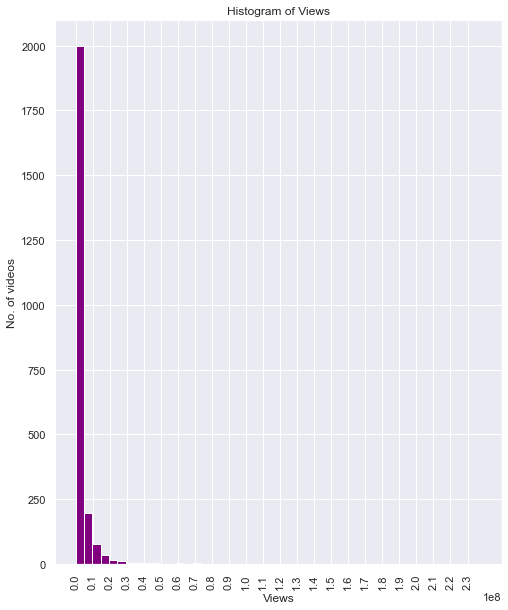

In [23]:
# Distribution of Views
fig, ax = plt.subplots()
_ = sns.distplot(num_agg["views_total"], kde=False, color = 'purple', 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.4e8, 50), ax = ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2.5e8)
_ = ax.set_title(label = 'Histogram of Views', loc = 'center')
_ = plt.xticks(rotation=90)

C:\Users\fcbmu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


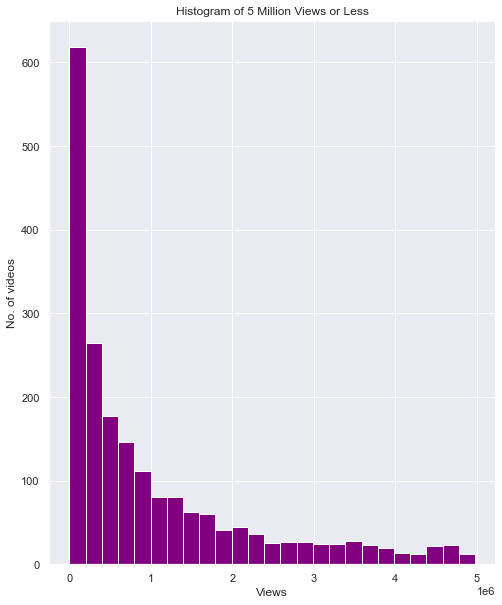

In [26]:
# Majority of the videos have less than or equal to 5 million views
fig, ax = plt.subplots()
_ = sns.distplot(num_agg[num_agg["views_total"] <= 5e6]["views_total"], kde=False, 
                 color='purple', hist_kws={'alpha': 1}, ax = ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")
_ = ax.set_title(label = 'Histogram of 5 Million Views or Less', loc = 'center')

In [27]:
# What's the percentage of videos that have 5 million views or less?
views_5m = num_agg[num_agg["views_total"] <= 5e6]["views_total"].count() / num_agg["views_total"].count() * 100

display('Percentage of Videos that have 500 million views or less: ' + str(round(views_5m, 2)) + '%')

'Percentage of Videos that have 500 million views or less: 84.81%'

The first histogram shows the distribution of YouTube videos' views. After filtering the videos less than or equal to 5 million views, the distribution is skewed to the right which is a positive skewness. Next, let's see the likes distribution.

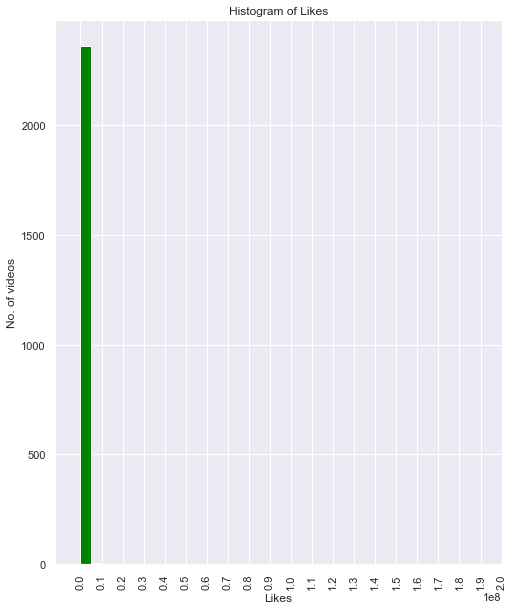

In [31]:
# Distribution of Likes
fig, ax = plt.subplots()
_ = sns.distplot(num_agg["likes_total"], kde=False, color = 'green', 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.4e8, 50), ax = ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2e8)
_ = ax.set_title(label = 'Histogram of Likes', loc = 'center')
_ = plt.xticks(rotation=90)

C:\Users\fcbmu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


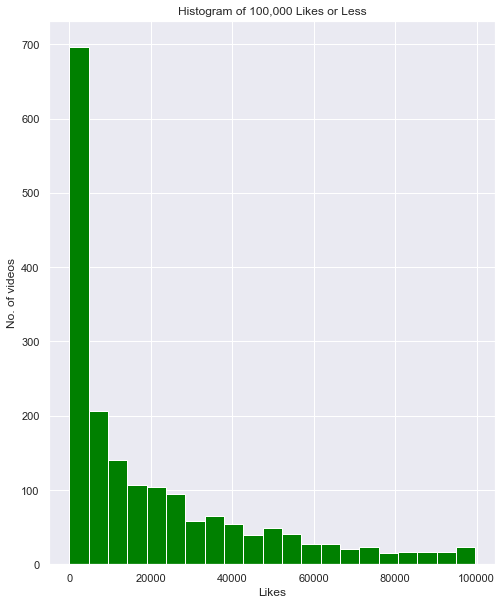

In [36]:
# Distribution of less than or equal to 100K likes
fig, ax = plt.subplots()
_ = sns.distplot(num_agg[num_agg["likes_total"] <= 100000]['likes_total'], kde=False, 
                 color='green', hist_kws={'alpha': 1}, ax = ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")
_ = ax.set_title(label = 'Histogram of 100,000 Likes or Less', loc = 'center')

In [37]:
# What's the percentage of videos that have less than or equal to 100K likes?
likes_100k = num_agg[num_agg["likes_total"] <= 1100000]['likes_total'].count() / num_agg["likes_total"].count() * 100

display('Percentage of Videos that have less than or equal to 100 million likes: ' + str(round(likes_100k, 2)) + '%')

'Percentage of Videos that have less than or equal to 100 million likes: 98.27%'

The first histogram of likes shows the distribution of YouTube videos. After filtering the videos with less than or equal to 100,000 likes, the distribution is skewed to the right which is a positive skewness. Let's see the dislikes distribution.

C:\Users\fcbmu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


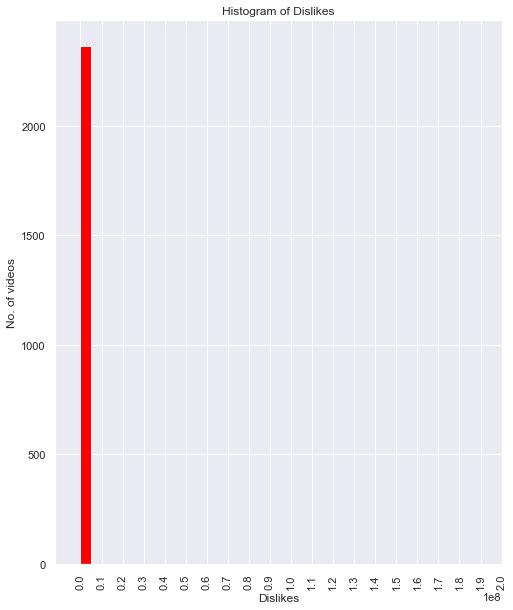

In [38]:
# Distribution of Dislikes
fig, ax = plt.subplots()
_ = sns.distplot(num_agg["dislikes_total"], kde=False, color = 'red', 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.4e8, 50), ax = ax)
_ = ax.set(xlabel="Dislikes", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2e8)
_ = ax.set_title(label = 'Histogram of Dislikes', loc = 'center')
_ = plt.xticks(rotation=90)

C:\Users\fcbmu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


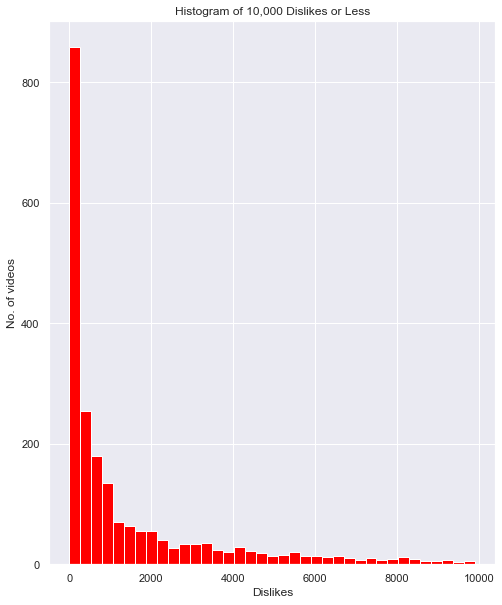

In [53]:
# Distribution of less than or equal to 10k dislikes
fig, ax = plt.subplots()
_ = sns.distplot(num_agg[num_agg["dislikes_total"] <= 10000]['dislikes_total'], kde=False, 
                 color='red', hist_kws={'alpha': 1}, ax = ax)
_ = ax.set(xlabel="Dislikes", ylabel="No. of videos")
_ = ax.set_title(label = 'Histogram of 10,000 Dislikes or Less', loc = 'center')

In [45]:
# What's the percentage of videos that have less than or equal to 10k dislikes?
dislikes_10k = num_agg[num_agg["dislikes_total"] <= 1e6]['dislikes_total'].count() / num_agg['dislikes_total'].count() * 100

display('Percentage of Videos that have less than or equal to 1 million dislikes: ' + str(round(dislikes_10k, 2)) + '%')

'Percentage of Videos that have less than or equal to 1 million dislikes: 99.92%'

The first histogram of dislikes shows the distribution of YouTube videos. After filtering the videos with less than or eqaul to 10,000 dislikes, the distribution is skewed to the right which is a positive skewness. Let's see the # of comments distribution.

C:\Users\fcbmu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


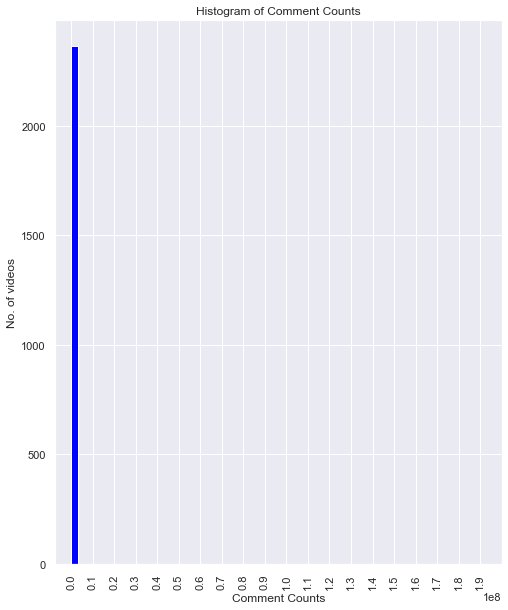

In [46]:
# Distribution of comment_count
fig, ax = plt.subplots()
_ = sns.distplot(num_agg["comment_total"], kde=False, color = 'blue', 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 1.5e08, 50), ax = ax)
_ = ax.set(xlabel="Comment Counts", ylabel="No. of videos", xticks=np.arange(0, 2e8, 1e7))
_ = ax.set_xlim(right=2e8)
_ = ax.set_title(label = 'Histogram of Comment Counts', loc = 'center')
_ = plt.xticks(rotation=90)

C:\Users\fcbmu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


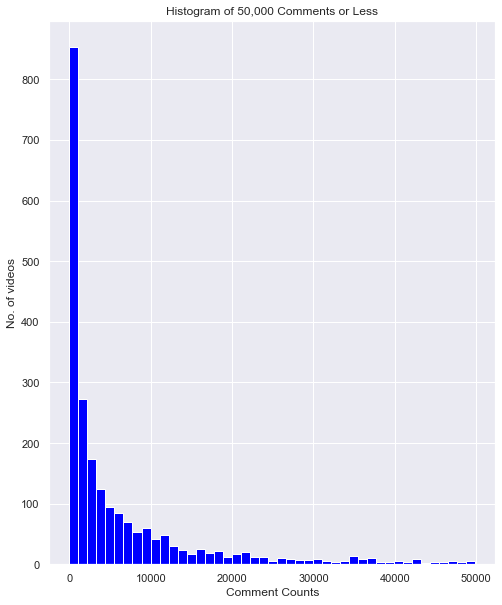

In [56]:
# Distribution of less than or equal to 50k comments count
fig, ax = plt.subplots()
_ = sns.distplot(num_agg[num_agg["comment_total"] <= 50000]['comment_total'], kde=False, 
                 color='blue', hist_kws={'alpha': 1}, ax = ax)
_ = ax.set(xlabel="Comment Counts", ylabel="No. of videos")
_ = ax.set_title(label = 'Histogram of 50,000 Comments or Less', loc = 'center')

In [54]:
# What's the percentage of videos that have less than or equal to 50k comments count?
comments_50k = num_agg[num_agg["comment_total"] <= 500000]['comment_total'].count() / num_agg['comment_total'].count() * 100

display('Percentage of Videos that have less than or equal to 5 million comments: ' + str(round(comments_50k, 2)) + '%')

'Percentage of Videos that have less than or equal to 5 million comments: 99.66%'

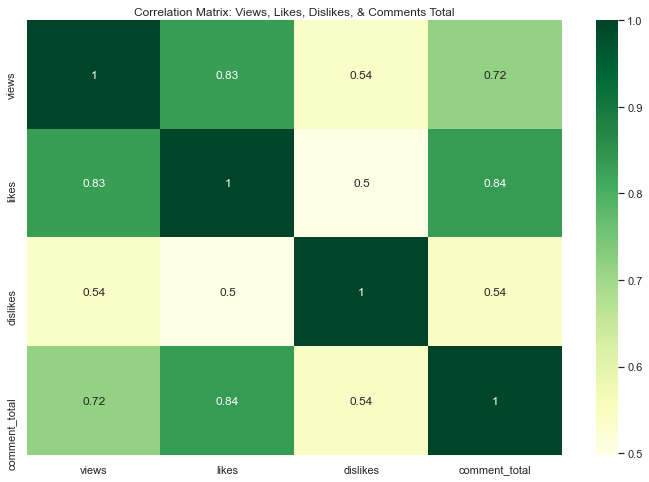

In [67]:
# Correlation Matrix
corr = videos[['views', 'likes', 'dislikes', 'comment_total']]
corrMatrix = corr.corr()

plt.figure(figsize=(12,8)) 
sns.heatmap(corrMatrix, annot = True, cmap = 'YlGn').set_title('Correlation Matrix: Views, Likes, Dislikes, & Comments Total')
plt.show()

### 3.1 Which category trending?

In [7]:
videos.head(2)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,category
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09,Science & Technology


In [8]:
# creating a smaller dataframe so it can graph faster
views_cat_ordered = videos.groupby(['category'])['views'].sum().sort_values(ascending=False)
views_cat_ordered

category
Entertainment           1848944372
Music                   1470692015
Comedy                   936255337
People & Blogs           856891892
Science & Technology     473462041
Howto & Style            467231042
Film & Animation         392920664
News & Politics          337015312
Sports                   298658073
Education                182892545
Pets & Animals            75562909
Autos & Vehicles          70492489
Gaming                    55848709
Travel & Events           22273972
Shows                        16985
Name: views, dtype: int64

In [9]:
views_cat_ordered = views_cat_ordered.to_frame(name = 'total views')
views_cat_ordered = views_cat_ordered.reset_index(drop=False) 
views_cat_ordered

,category,total views
0,Entertainment,1848944372
1,Music,1470692015
2,Comedy,936255337
3,People & Blogs,856891892
4,Science & Technology,473462041
5,Howto & Style,467231042
6,Film & Animation,392920664
7,News & Politics,337015312
8,Sports,298658073
9,Education,182892545


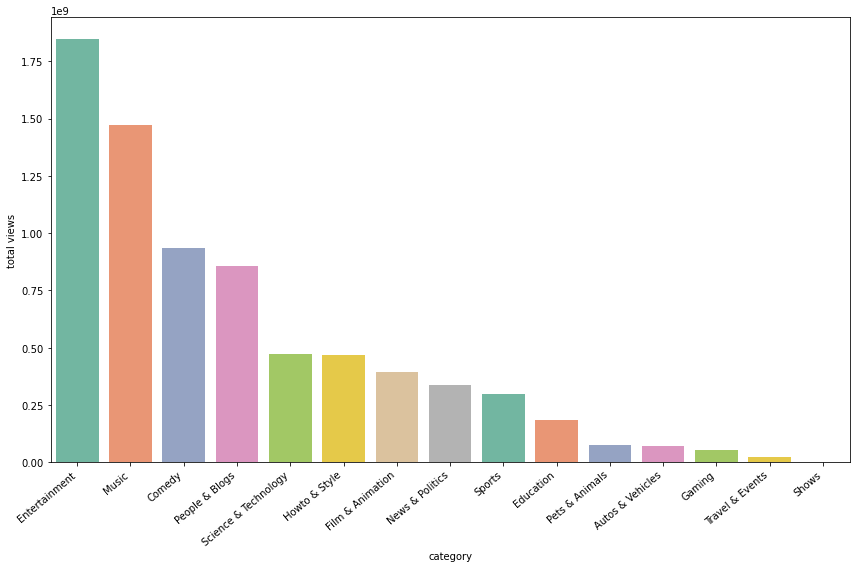

In [10]:
# gave up plotly cause it quitted like 10 times
# trying regular seaborn 
plt.figure(figsize=(12,8)) 
ax = sns.barplot(x = 'category', y = 'total views', data = views_cat_ordered, palette = "Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

## 3.2 Categories by their average sentiment scores

In [339]:
# categories by their average compound scores
score_cat = videos.groupby('category')['avg_score'].mean().sort_values(ascending=False)

In [340]:
# converting series to dataframe, make it easier for graphing
score_cat = score_cat.to_frame()
score_cat = score_cat.reset_index(drop = False)
score_cat

,category,avg_score
0,Howto & Style,0.307971
1,Travel & Events,0.244442
2,Music,0.243152
3,Pets & Animals,0.240486
4,People & Blogs,0.148938
5,Gaming,0.143289
6,Entertainment,0.128772
7,Film & Animation,0.123136
8,Sports,0.121471
9,Comedy,0.116267


In [341]:
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

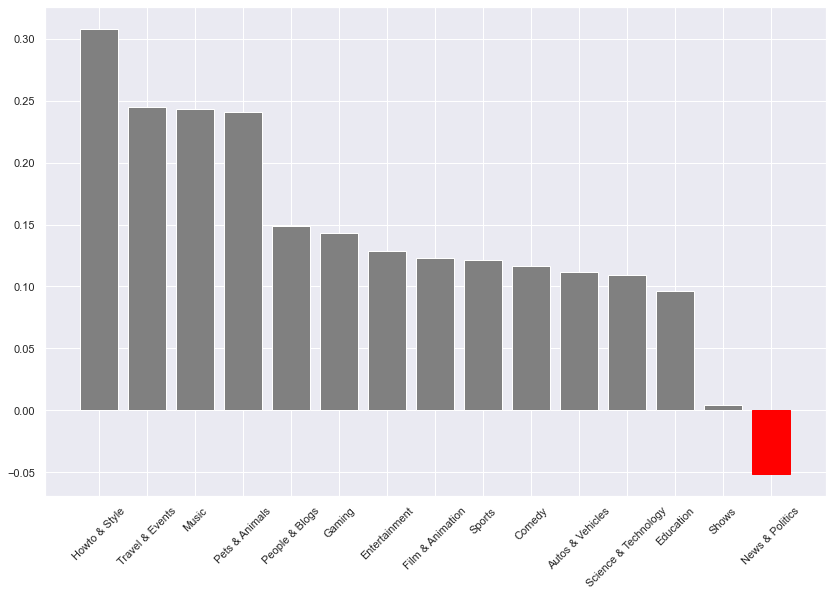

In [342]:
plt.figure(figsize=(14, 9))
bars = plt.bar(x = 'category', height = 'avg_score', data = score_cat, color='grey')
bars[-1].set_color('red')
plt.xticks(rotation=45)

# adjust the title & lables further

In [343]:
# pull comments of the most negative comments out of news&politics & do LDA on them 
videos[videos['avg_score'] == videos['avg_score'].min()]['video_id'].unique()

array(['2bOeaS1wREE'], dtype=object)

In [344]:
# pull comments from video_id of YMDGPSWWA18 from the comments dataset
comments[comments['video_id'] == 'YMDGPSWWA18']['comment_text'].unique()
# the actual comments doesn't seem to reveal that much 

array([], dtype=object)

In [345]:
# what about tags?
d = videos[videos['avg_score'] == videos['avg_score'].min()]
d[d['video_id'] == 'YMDGPSWWA18']['tags'].unique()

array([], dtype=object)

In [346]:
# pull tags from the most negative comments from news&politics 
most_neg = videos[videos['category'] == 'News & Politics'].sort_values(by = 'avg_score', ascending=False)
#tags = pd.DataFrame({"tags": [tags]})
type(most_neg)

pandas.core.frame.DataFrame

In [347]:
tags = most_neg['tags'].map(lambda x:x.lower().split('|')).values
splt_tags = ' '.join(most_neg['tags'])

## 3.3 Generate wordcloud of the most negative videos from "News & Politics" category

In [348]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

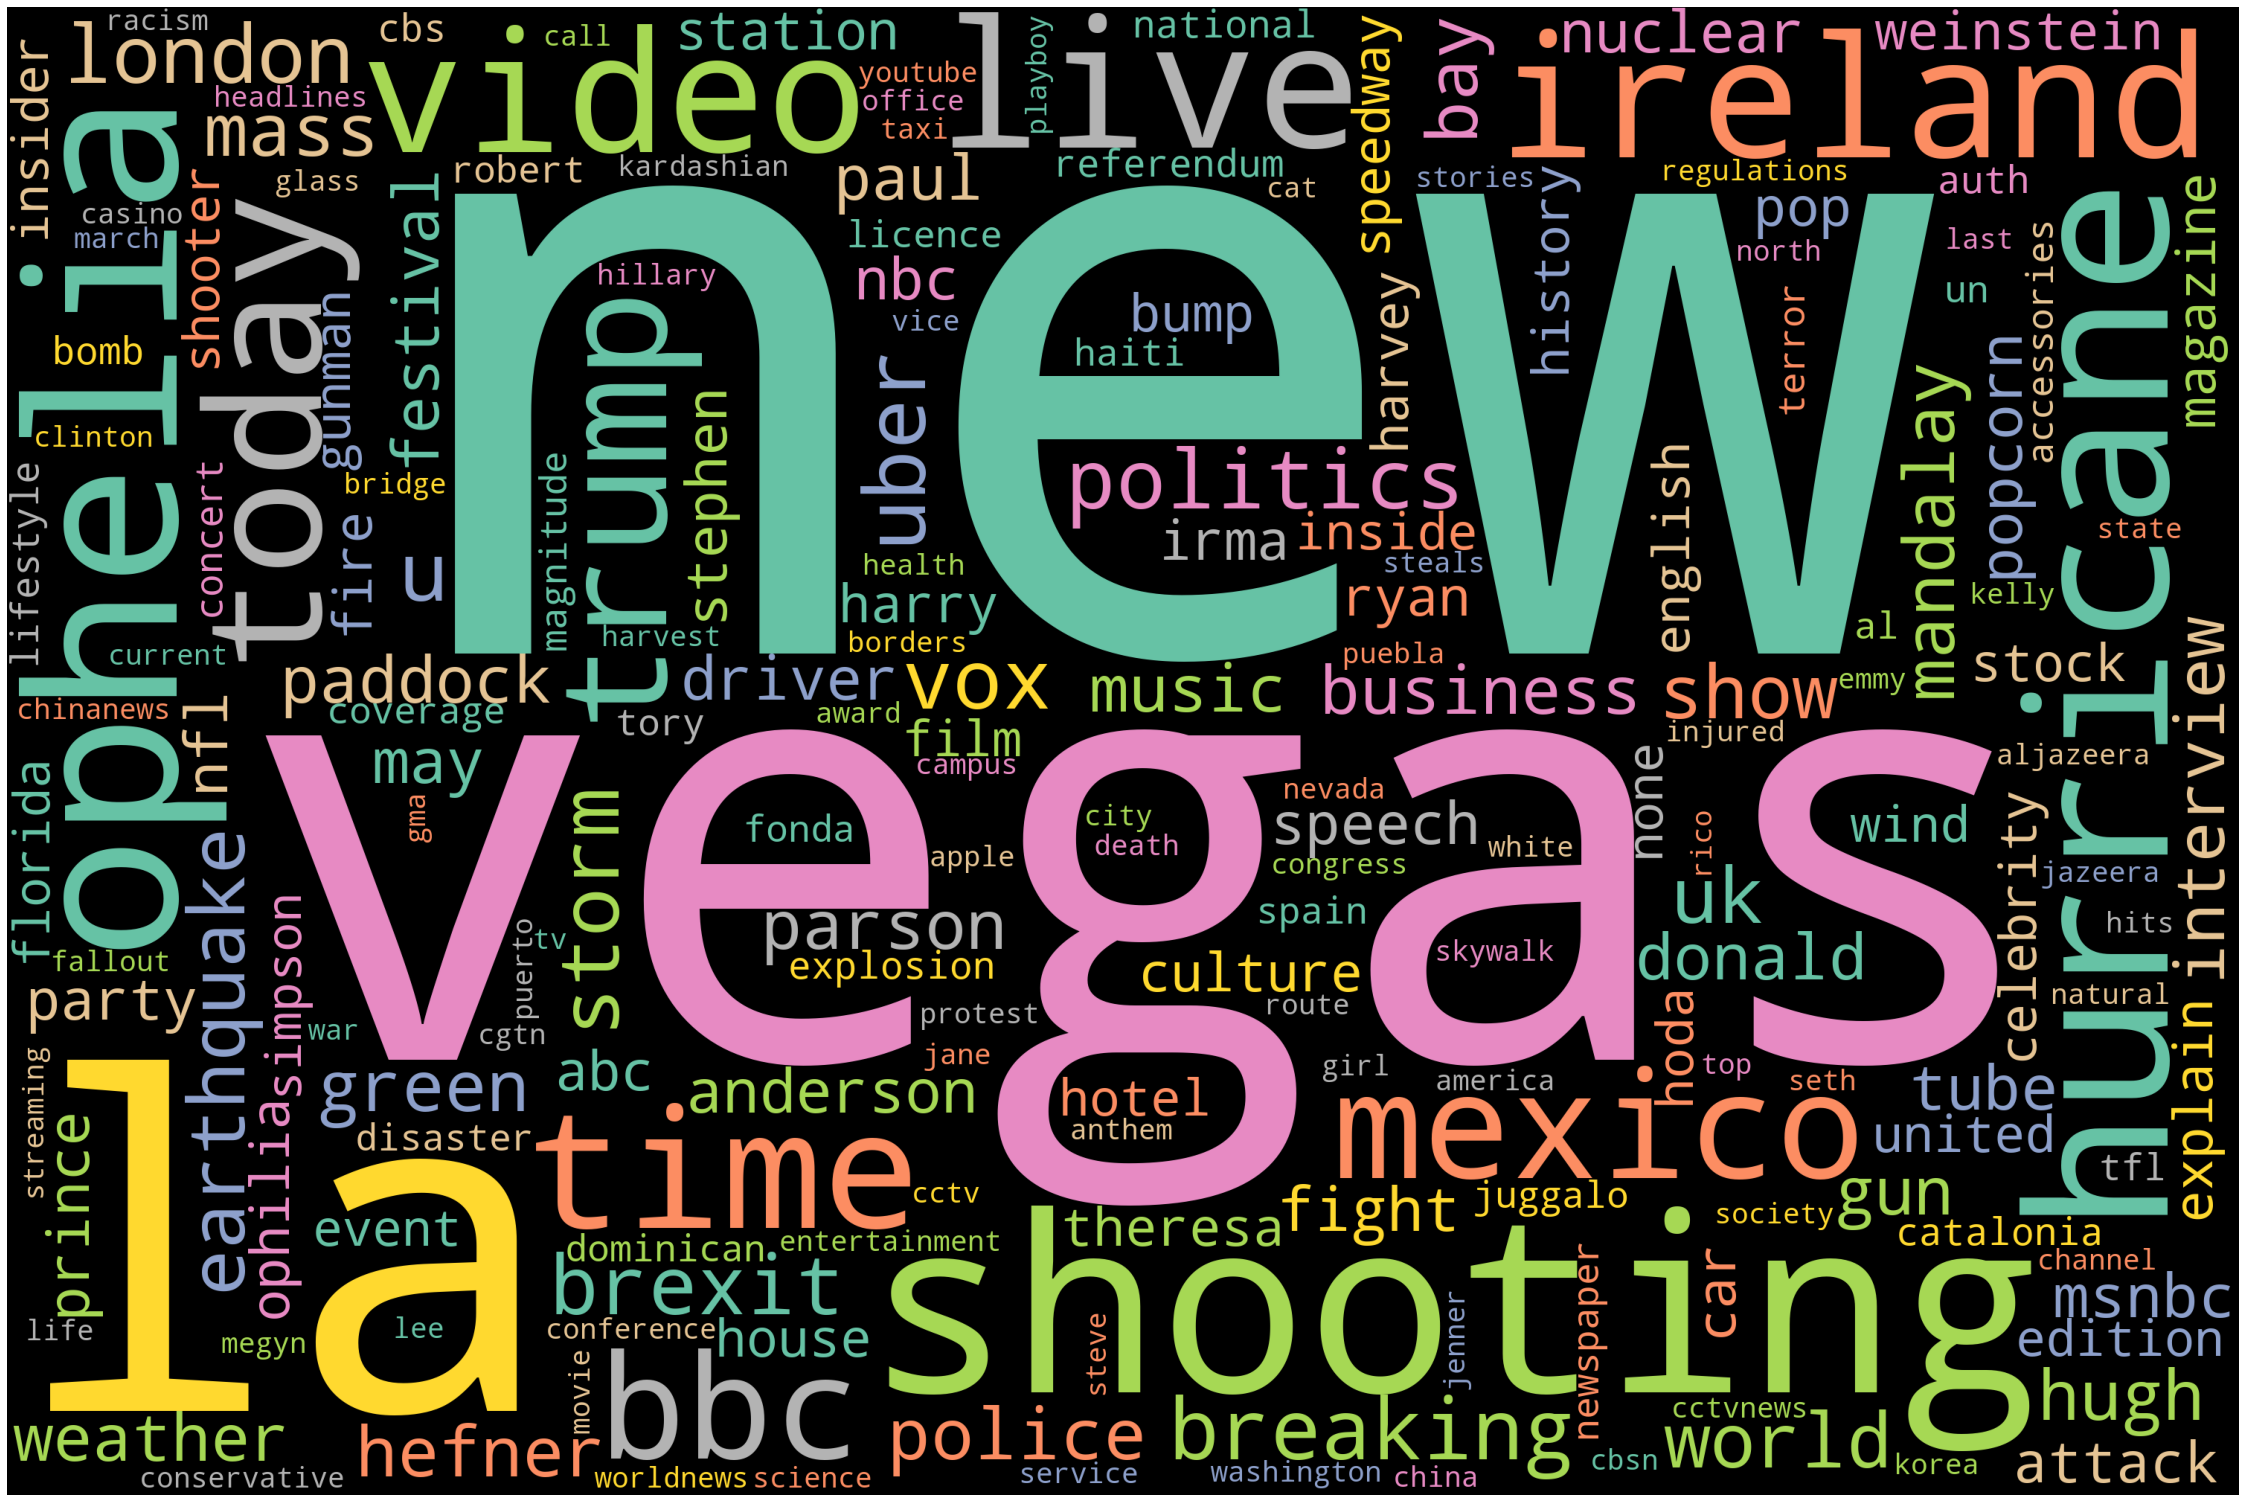

In [349]:
wordcloud = WordCloud(width = 3000, height = 2000, 
                      random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(' '.join(splt_tags.lower().split('|')))
# Plot
plot_cloud(wordcloud)

In [350]:
videos.head(2)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,category,avg_score,OverallSentiment
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment,0.069781,positive
1,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Entertainment,0.069781,positive


## 3.4 Categories by their views, likes and dislikes

In [11]:
# need to take the logs first, the boxplot looks too weird otherwise
videos['likes_log'] = np.log(videos['likes']+1)
videos['views_log'] = np.log(videos['views'] +1)
videos['dislikes_log'] = np.log(videos['dislikes'] +1)

## Categories by views

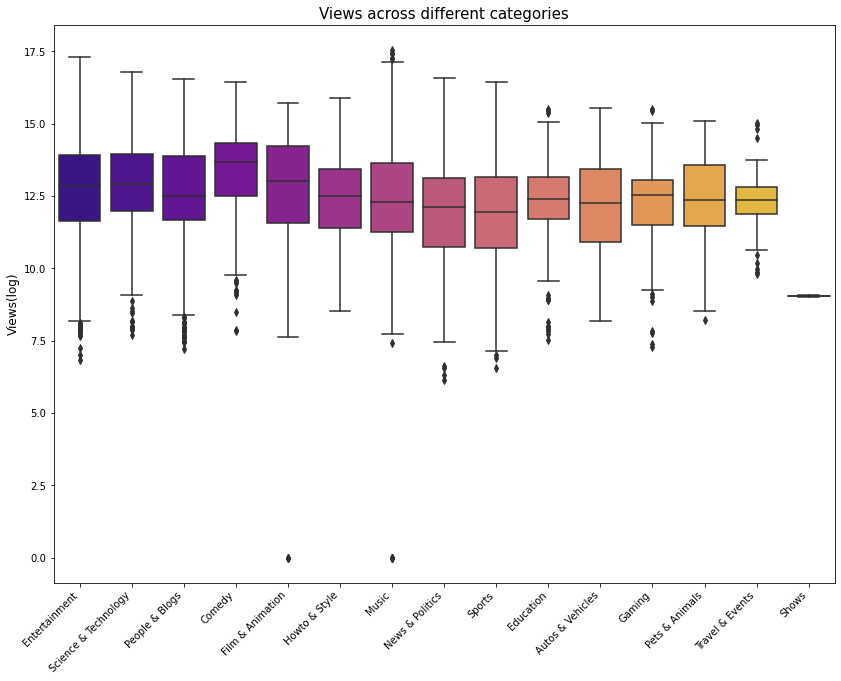

In [12]:
plt.figure(figsize = (14,10))
g = sns.boxplot(x = 'category', y = 'views_log', data = videos, palette="plasma")
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Views across different categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Views(log)", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

## Categories by likes

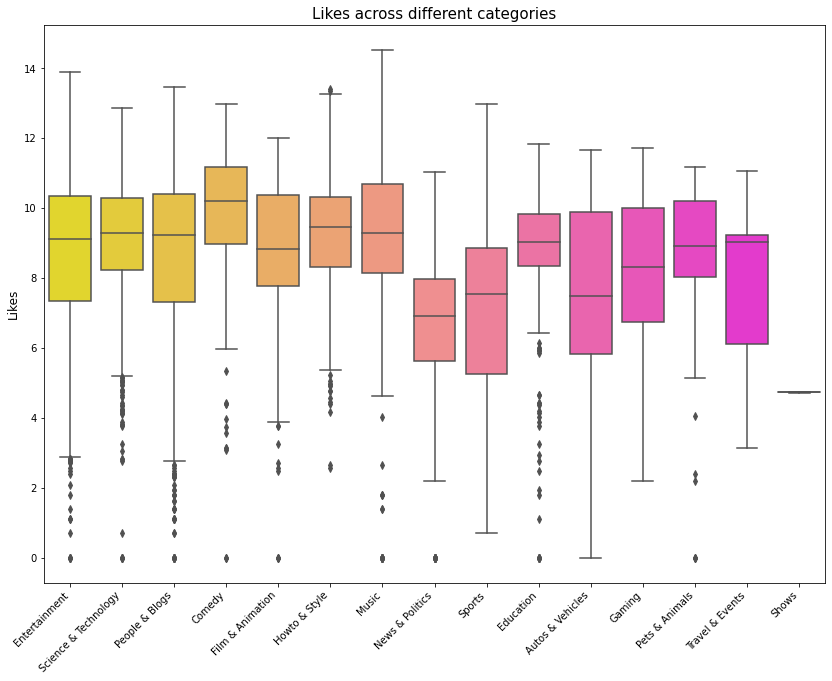

In [13]:
plt.figure(figsize = (14,10))
g = sns.boxplot(x = 'category', y = 'likes_log', data = videos, palette="spring_r")
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Likes across different categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

## Categories by dislikes

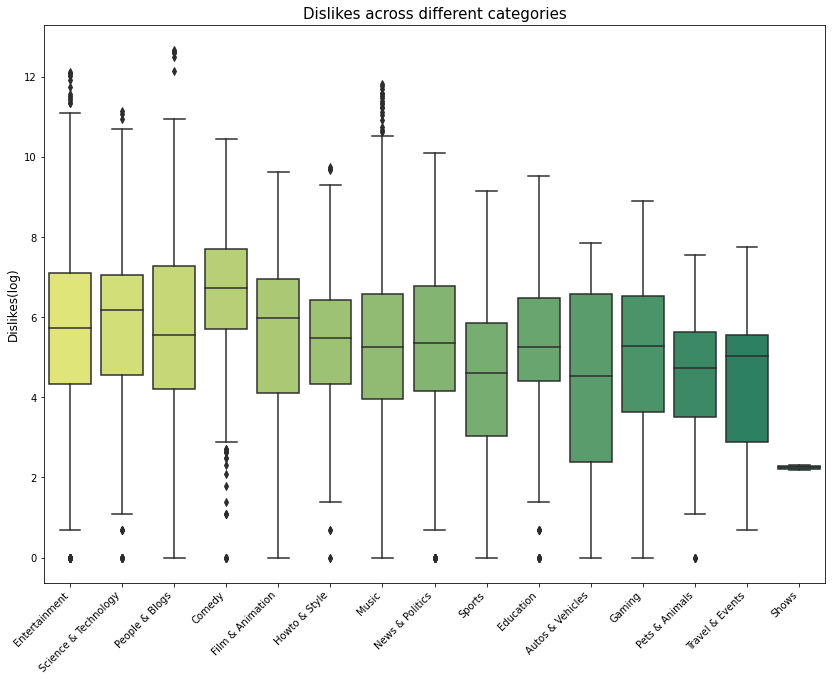

In [14]:
plt.figure(figsize = (14,10))
g = sns.boxplot(x = 'category', y = 'dislikes_log', data = videos, palette="summer_r")
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Dislikes across different categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Dislikes(log)", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

In [ ]:
# plot each category vs their polarity by time, by us & global


## 3.5 Which channels are trending?

### Top 10 trending channels by views

C:\Users\fcbmu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Top 10 Trending Youtube Channels')

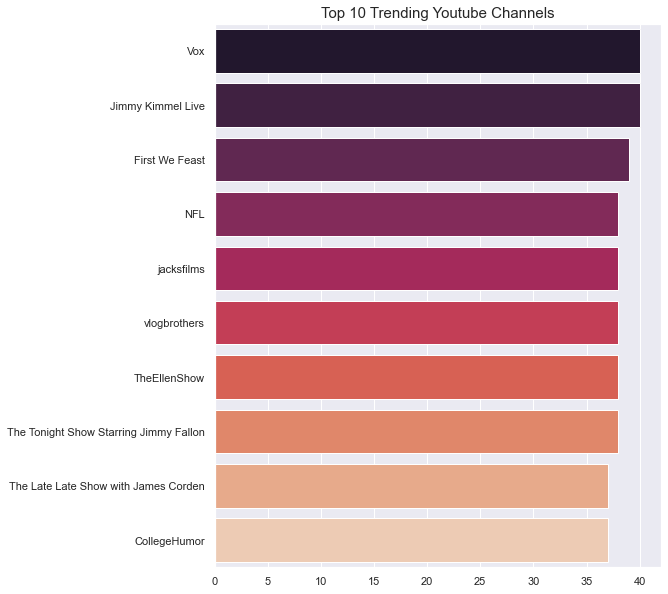

In [15]:
# top 10 trending channels by views
sns.set(rc={'figure.figsize':(8,10)})
top10channel = videos.groupby(["channel_title"]).size().sort_values(ascending = False).head(10)
sns.barplot(top10channel.values, 
            top10channel.index.values, 
            palette = "rocket").set_title("Top 10 Trending Youtube Channels", fontsize=15)

## 3.6 Top 1 Trending Channel: Likes & Dislikes by Views

In [365]:
# likes & views ratio for top 1 trending channel 
llate_show = videos[videos['channel_title'] == 'The Late Late Show with James Corden']
llate_show.head(2)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,category,avg_score,OverallSentiment,likes_log,views_log,dislikes_log
100113,qJJHhVf3_ZM,Gwyneth Paltrow Crashes James' Goop Magazine Rant,The Late Late Show with James Corden,24,James Corden|The Late Late Show|Colbert|late n...,220661,2070,449,352,https://i.ytimg.com/vi/qJJHhVf3_ZM/default.jpg,13.09,Entertainment,-0.077677,negative,7.635787,12.304387,6.109248
100114,qJJHhVf3_ZM,Gwyneth Paltrow Crashes James' Goop Magazine Rant,The Late Late Show with James Corden,24,James Corden|The Late Late Show|Colbert|late n...,220661,2070,449,352,https://i.ytimg.com/vi/qJJHhVf3_ZM/default.jpg,13.09,Entertainment,-0.077677,negative,7.635787,12.304387,6.109248


### Plot a regression between likes & views 

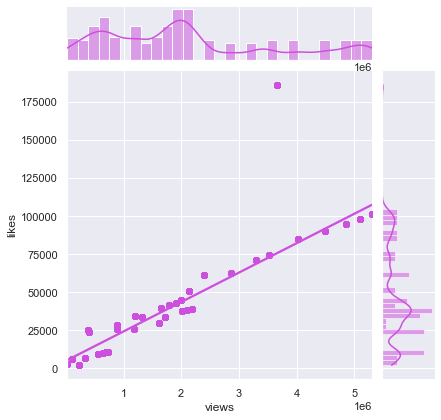

In [400]:
colors = ["#CD4FDE"]
sns.set_palette(sns.color_palette(colors))
sns.jointplot(x='views',y='likes',data=llate_show,kind='reg')
plt.show()

### Plot a regression between dislikes & views 

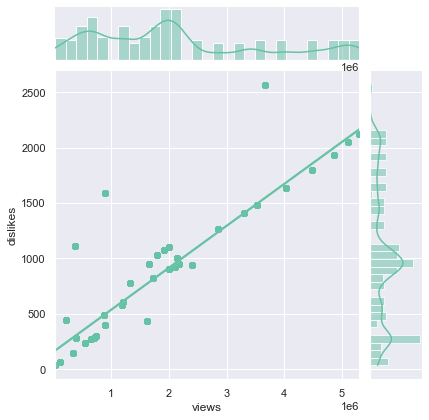

In [403]:
# plot a regression between dislikes & views 
sns.set_palette(sns.color_palette("Set2"))
sns.jointplot(x='views',y='dislikes',data=llate_show,kind='reg')
plt.show()